In [ ]:
import os
import numpy as np
import pandas as pd
import wave
from google.colab import drive
import tensorflow.compat.v1 as tf
import zipfile
import librosa
from keras import layers
import math
import shutil
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

prefix = '/content/drive/MyDrive/DAIC-WOZ'

In [ ]:
# Load CSV files
train_split_df = pd.read_csv(os.path.join(prefix, 'train_split_Depression_AVEC2017.csv'))
test_split_df = pd.read_csv(os.path.join(prefix, 'dev_split_Depression_AVEC2017.csv'))

train_split_num = train_split_df['Participant_ID'].tolist()
test_split_num = test_split_df['Participant_ID'].tolist()
train_split_label = train_split_df['PHQ8_Binary'].tolist()
test_split_label = test_split_df['PHQ8_Binary'].tolist()

# Sample Usage
save_dir = os.path.join('/content/drive/MyDrive', 'DAIC-Features')

audio_train = np.load(os.path.join(save_dir, 'train_audio_clf.npz'))
text_train = np.load(os.path.join(save_dir, 'train_text_clf.npz'))
lablels_train = np.load(os.path.join(save_dir, 'train_label_clf.npz'))

audio_test = np.load(os.path.join(save_dir, 'test_audio_clf.npz'))
text_test = np.load(os.path.join(save_dir, 'test_text_clf.npz'))
labels_test = np.load(os.path.join(save_dir, 'test_label_clf.npz'))

In [ ]:
train_numbers = [num for num in train_split_num]
test_numbers = [num for num in test_split_num]

text_subs_train = [text_train[f'text_{num}'] for num in train_numbers]
audio_subs_train = [audio_train[f'audio_{num}'] for num in train_numbers]
labels_train = [lablels_train[f'label_{num}'] for num in train_numbers]

text_subs_test = [text_test[f'text_{num}'] for num in test_numbers]
audio_subs_test = [audio_test[f'audio_{num}'] for num in test_numbers]
labels_test = [labels_test[f'label_{num}'] for num in test_numbers]

In [ ]:
class SentencesDataset(Dataset):
    def __init__(self, sentences_list, labels_list, tokenizer, max_len):
        self.sentences_list = sentences_list
        self.labels_list = [int(label) for label in labels_list]  # Ensure labels are integers
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences_list)

    def __getitem__(self, index):
        sentences = self.sentences_list[index]
        label = self.labels_list[index]

        if len(sentences) == 0:
            return None

        encodings = [
            self.tokenizer(
                sentence,
                padding='max_length',
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )
            for sentence in sentences
        ]
        input_ids = torch.stack([e['input_ids'].squeeze(0) for e in encodings])
        attention_masks = torch.stack([e['attention_mask'].squeeze(0) for e in encodings])
        return {'input_ids': input_ids, 'attention_mask': attention_masks, 'label': label}

def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]

    if len(batch) == 0:
        return None

    max_sentences = max(len(item['input_ids']) for item in batch)
    max_len = batch[0]['input_ids'].size(1)
    padded_input_ids = []
    padded_attention_masks = []
    labels = []

    for item in batch:
        num_sentences = len(item['input_ids'])
        padding_size = max_sentences - num_sentences
        padded_input_ids.append(
            torch.cat([item['input_ids'], torch.zeros((padding_size, max_len), dtype=torch.long)], dim=0)
        )
        padded_attention_masks.append(
            torch.cat([item['attention_mask'], torch.zeros((padding_size, max_len), dtype=torch.long)], dim=0)
        )
        labels.append(int(item['label']))  # Ensure label is an integer

    return {
        'input_ids': torch.stack(padded_input_ids),
        'attention_mask': torch.stack(padded_attention_masks),
        'label': torch.tensor(labels, dtype=torch.long)
    }


class TransformerClassifier(nn.Module):
    def __init__(self, pretrained_model_name, num_classes, n_heads=4, n_layers=2, dim_feedforward=512, dropout=0.3):
        super(TransformerClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name, output_attentions=True)
        self.hidden_size = self.bert.config.hidden_size
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hidden_size,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        batch_size, num_sentences, seq_len = input_ids.size()
        input_ids = input_ids.view(-1, seq_len)
        attention_mask = attention_mask.view(-1, seq_len)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        sentence_embeddings = outputs.last_hidden_state[:, 0, :]
        bert_attentions = outputs.attentions
        sentence_embeddings = sentence_embeddings.view(batch_size, num_sentences, self.hidden_size)
        transformer_output = self.transformer_encoder(sentence_embeddings)
        subject_embeddings = transformer_output.mean(dim=1)
        x = self.dropout(subject_embeddings)
        logits = self.fc(x)
        return logits, bert_attentions

def evaluate_model_with_attention(model, dataloader, device):
    model.eval()
    all_bert_attentions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs, bert_attentions = model(input_ids, attention_mask)
            all_bert_attentions.append(bert_attentions)
            break
    return all_bert_attentions

max_len = 40
batch_size = 4
num_classes = 2
learning_rate = 4e-5
num_epochs = 15

pretrained_model_name = 'bert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
train_data = SentencesDataset(text_subs_train, labels_train, tokenizer, max_len)
test_data = SentencesDataset(text_subs_test, labels_test, tokenizer, max_len)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

model = TransformerClassifier(pretrained_model_name, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs, _ = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

attention_weights = evaluate_model_with_attention(model, test_loader, device)
layer_1_attention = attention_weights[0][0]
print(f"Attention weights shape: {layer_1_attention.shape}")
print("Training Complete.")


Epoch 1/15, Loss: 0.8275, Accuracy: 0.6168
Epoch 2/15, Loss: 0.6217, Accuracy: 0.7009
Epoch 3/15, Loss: 0.6211, Accuracy: 0.6729
Epoch 4/15, Loss: 0.6150, Accuracy: 0.7290
Epoch 5/15, Loss: 0.6148, Accuracy: 0.6542
Epoch 6/15, Loss: 0.5322, Accuracy: 0.7757
Epoch 7/15, Loss: 0.5740, Accuracy: 0.7383
Epoch 8/15, Loss: 0.3671, Accuracy: 0.8692
Epoch 9/15, Loss: 0.3045, Accuracy: 0.8972
Epoch 10/15, Loss: 0.1247, Accuracy: 0.9533
Epoch 11/15, Loss: 0.0656, Accuracy: 0.9813
Epoch 12/15, Loss: 0.0241, Accuracy: 0.9907
Epoch 13/15, Loss: 0.0047, Accuracy: 1.0000
Epoch 14/15, Loss: 0.0015, Accuracy: 1.0000
Epoch 15/15, Loss: 0.0010, Accuracy: 1.0000
Attention weights shape: torch.Size([184, 12, 40, 40])
Training Complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
batch_idx = 0
sentence_idx = 30
head_indices = [0, 1, 2, 3]

attention_matrices = [layer_1_attention[batch_idx, head_idx].cpu().numpy() for head_idx in head_indices]
input_ids_batch = input_ids[batch_idx, sentence_idx]
tokens = tokenizer.convert_ids_to_tokens(input_ids_batch.tolist())

num_tokens = len(tokens)
attention_matrices = [matrix[:num_tokens, :num_tokens] for matrix in attention_matrices]

sns.set(font_scale=1.8)
fig, axes = plt.subplots(2, 2, figsize=(28, 24), dpi=900)

for i, ax in enumerate(axes.flat):
    sns.heatmap(
        attention_matrices[i],
        cmap="viridis",
        xticklabels=tokens,
        yticklabels=tokens,
        ax=ax,
        cbar=True
    )
    ax.set_title(f"Attention Head {head_indices[i]}", fontsize=18)
    ax.set_xlabel("Keys", fontsize=16)
    ax.set_ylabel("Queries", fontsize=16)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)

plt.suptitle(f"Attention Weights Heatmaps - Batch {batch_idx}, Sentence {sentence_idx}", fontsize=20)
plt.tight_layout()
plt.show()


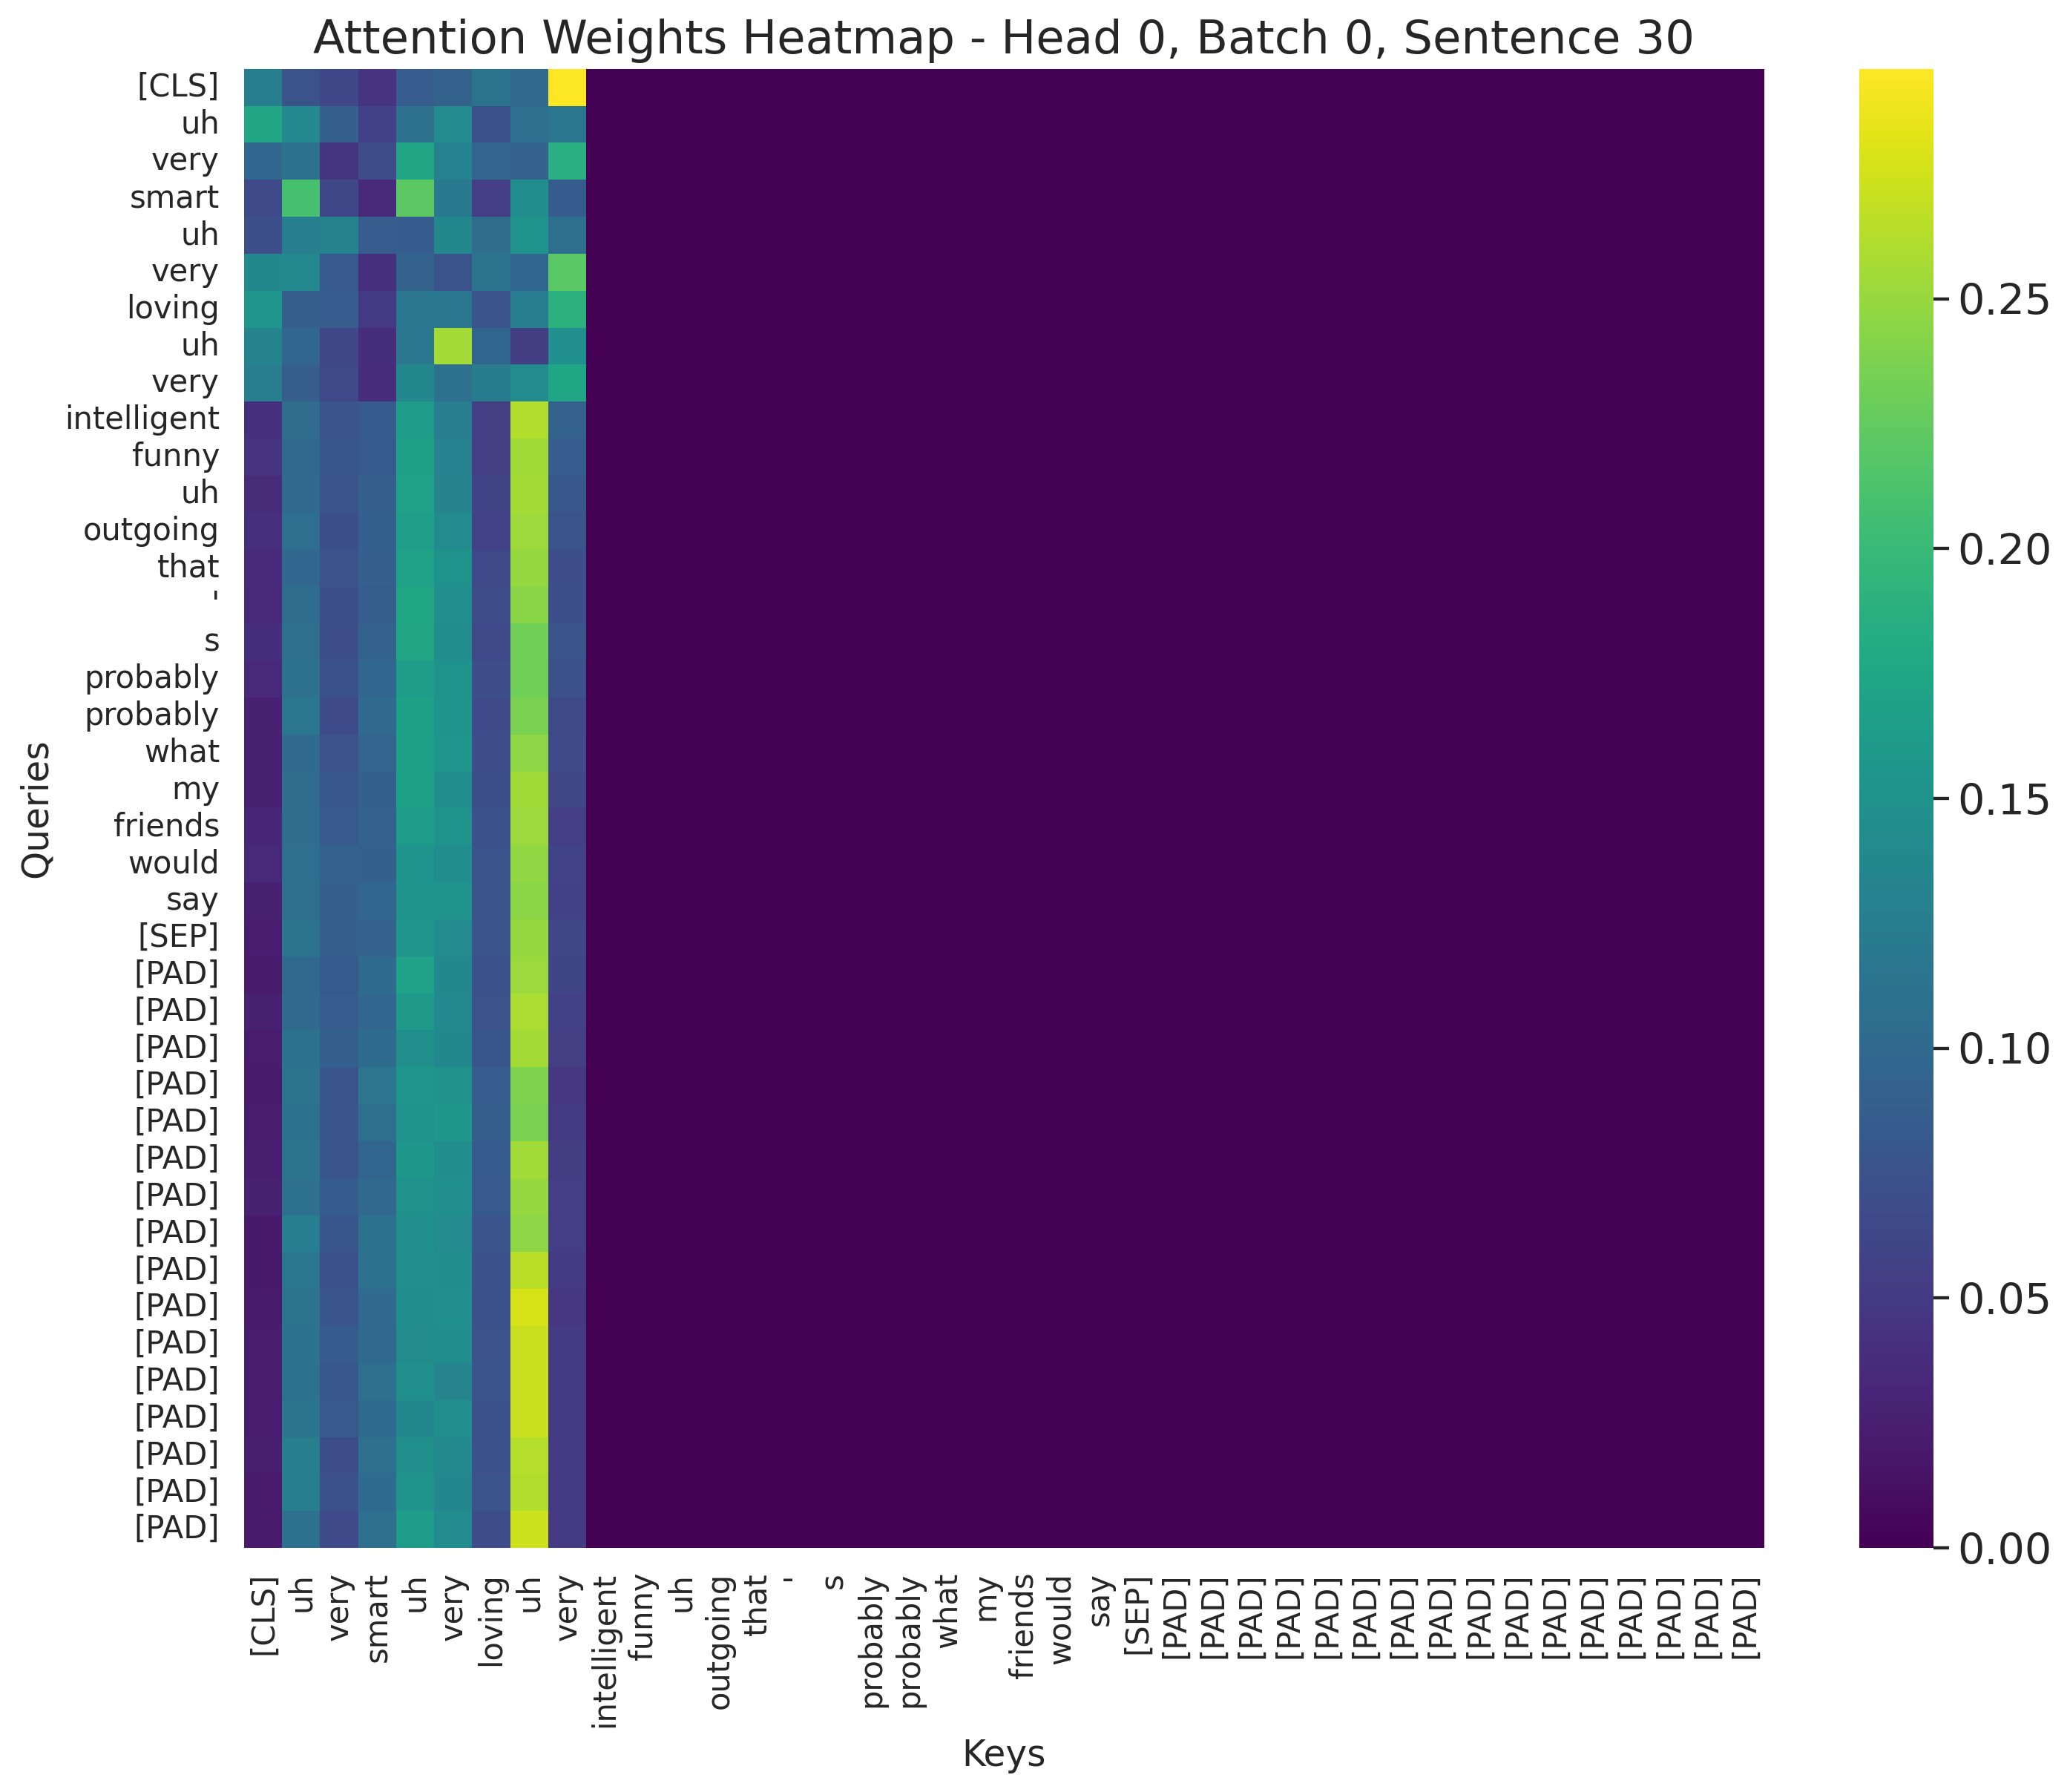

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
batch_idx = 0
sentence_idx = 30
head_idx = 0

attention_matrix = layer_1_attention[batch_idx, head_idx].cpu().numpy()
input_ids_batch = input_ids[batch_idx, sentence_idx]
tokens = tokenizer.convert_ids_to_tokens(input_ids_batch.tolist())

num_tokens = len(tokens)
attention_matrix = attention_matrix[:num_tokens, :num_tokens]

sns.set(font_scale=1.5)
plt.figure(figsize=(12, 10), dpi=250)

sns.heatmap(
    attention_matrix,
    cmap="viridis",
    xticklabels=tokens,
    yticklabels=tokens,
    cbar=True
)

plt.title(f"Attention Weights Heatmap - Head {head_idx}, Batch {batch_idx}, Sentence {sentence_idx}", fontsize=18)
plt.xlabel("Keys", fontsize=14)
plt.ylabel("Queries", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()